In [1]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os
import sys
sys.path.append("../")
import PF
import ROI
import analysis_methods as am

C:\Users\Daniel\Anaconda3\lib\site-packages\html5lib\_trie\_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [50]:
importlib.reload(PF)
importlib.reload(ROI)
importlib.reload(am)

<module 'analysis_methods' from '..\\analysis_methods.py'>

In [3]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx

def plot_peak_region(roi, spectrum, sourcen_energies, key):
    target_peaks = roi.target_peaks
    spec = spectrum
    counts = spec.counts_vals
    energies = spec.bin_centers_kev
    idx = f_near(energies,key) 
    roi_low = idx - 50
    roi_high = idx + 50

    plot_counts = counts[roi_low:roi_high]
    plot_energies = energies[roi_low:roi_high]
        
    roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.roi_pars["%s" %key])
    rlow = roi_low_bins[0][0]
    rhi = roi_high_bins[0][-1]
    plot_counts = counts[rlow:rhi]
    plot_energies = energies[rlow:rhi]

    rlow = roi_low_bins[0][0]
    rhi = roi_low_bins[0][-1]
    low_counts = counts[rlow:rhi]
    low_energies = energies[rlow:rhi]

    rlow = roi_high_bins[0][0]
    rhi = roi_high_bins[0][-1]
    high_counts = counts[rlow:rhi]
    high_energies = energies[rlow:rhi]

    rlow = roi_peak_bins[0][0]
    rhi = roi_peak_bins[0][-1]
    peak_counts = counts[rlow:rhi]
    peak_energies = energies[rlow:rhi]

    fig,ax = plt.subplots()
    ax.plot(plot_energies,plot_counts)
    ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
    ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
    ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
    ax.set_yscale('log')
    plt.title("%s Peak" %key)

def efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
    eff = []
    eff_uncer = []
    for count,A,br,sigma_c,sigma_A in zip (roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
        eff.append(count/spec.livetime/A/br)
        eff_uncer.append(m.sqrt((sigma_c/A)**2+(count*sigma_A/A**2)**2)/br/spec.livetime)
    return eff, eff_uncer

In [4]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()
    #plt.savefig('peaks used in fit.png',dpi = 200)

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))
    #plt.savefig('Uncal spec.png',dpi = 200)


    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
    #plt.savefig('cal spec.png',dpi=200)

In [74]:
path = r'C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis'
spec = path + r'\NAA_eff_calibration_long.Spe'
bg = path + r'\background-long.Spe'
#ecal = path + r'\E-calibration-Eu152.Spe'
#this set of eff data was already energy calibrated

spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)
#ecal = bq.Spectrum.from_file(ecal)

counts = spec.counts_vals
energies = spec.bin_centers_kev
bg_counts = bg.counts_vals

SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\NAA_eff_calibration_long.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\background-long.Spe


In [6]:
#Find Lu-176, La-138, K-40
source_isotopes = np.array(['Lu_176_1','Lu_176_2','Lu_176_3',
                          'La_138_1','La_138_2',
                           'K-40']); #get counts under the peak subtrack the background
source_energies = np.array([88.34,
                            201.83,306.78,
                           788.742,1435.795,
                           1460.83]);
source_activities = np.array([16.259,
                              16.259,16.259,
                             11.646,11.646,
                              424.65]);#Bq/L, update this with correct mass, by .0098 g
branching_ratio = np.array([0.11,
                            0.86,0.94,
                           0.34,0.66,
                           0.11]);
activities_uncer = np.array([1.6259,
                             1.6259,1.6259,
                            0.02329,0.02329,
                            0.8493])
'''The real source energies:
Lu-176: 88.34, 201.83, 306.78
La-138: 788.742,1435.795
K-40: 1460.83'''
source_activities = source_activities * .0098 #accounting for NAA sample weight
activities_uncer = activities_uncer * .0098
print(source_activities)
print(type(source_energies[0]))
type(88.34)

[0.1593382 0.1593382 0.1593382 0.1141308 0.1141308 4.16157  ]
<class 'numpy.float64'>


float

In [7]:
roi = ROI.ROI(spec, bg, source_energies, 0)#0 subtracts bg after ROI is applied, (diff cal can work)
#roi_counts, roi_unc = roi.get_counts()
#print(roi_counts)
#print(roi_unc)

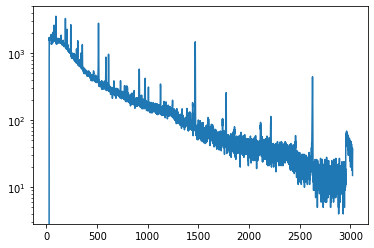

In [8]:
plt.plot(energies,counts)
plt.yscale('log')

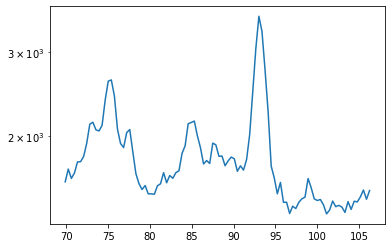

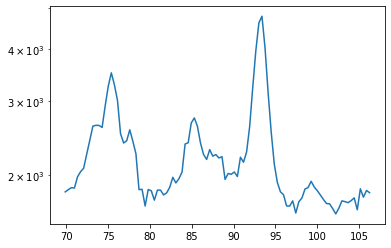

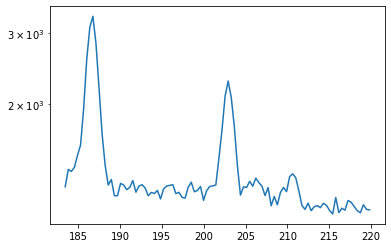

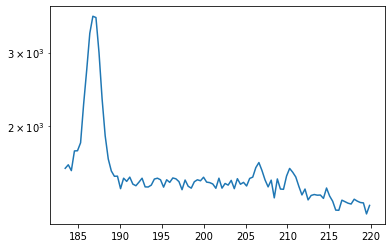

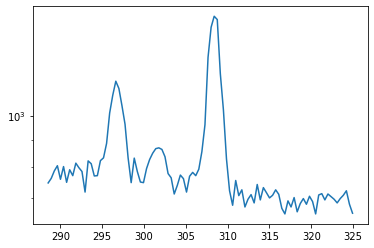

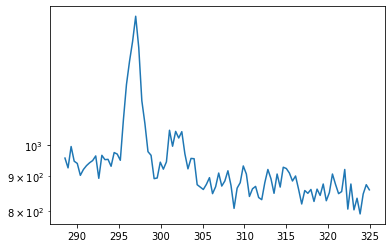

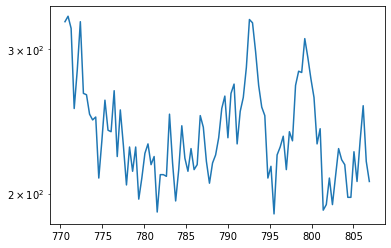

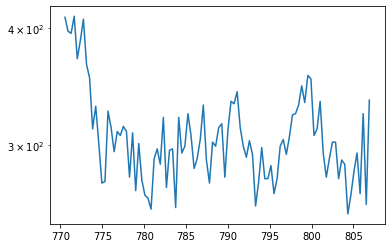

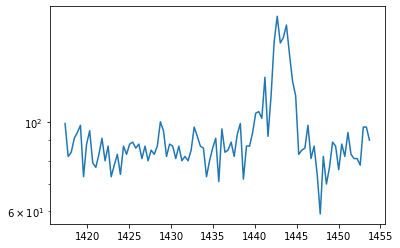

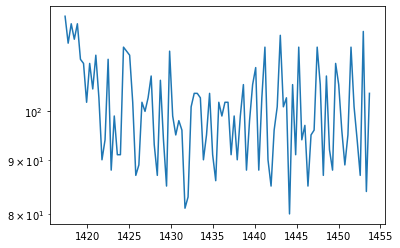

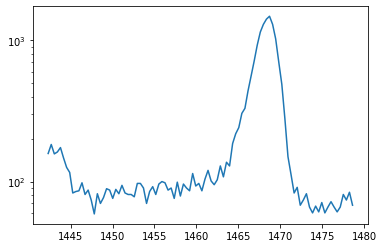

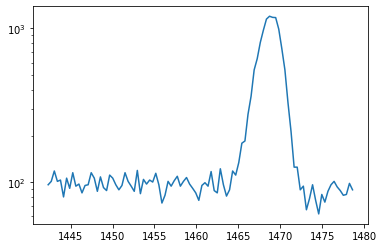

In [76]:
for i in source_energies:
    index0 = f_near(energies, i)
    plt.plot(energies[index0-50:index0+50], counts[index0-50:index0+50])
    plt.yscale('log')
    plt.show()
    plt.plot(energies[index0-50:index0+50], bg_counts[index0-50:index0+50])
    plt.yscale('log')
    plt.show()

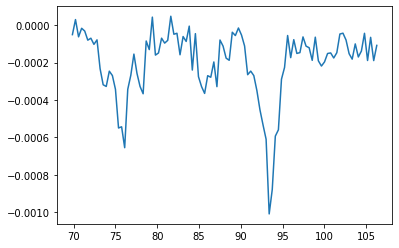

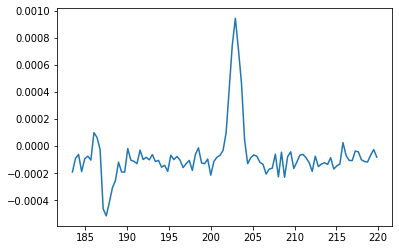

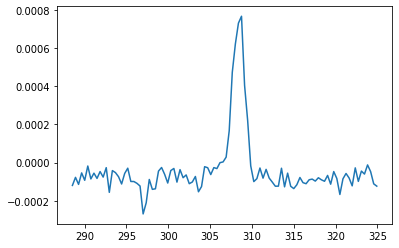

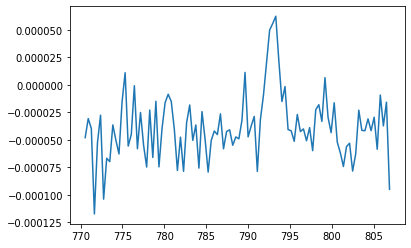

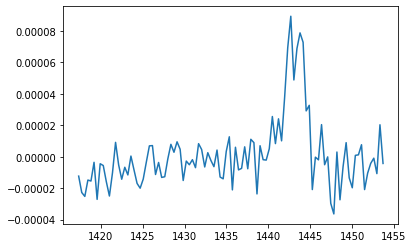

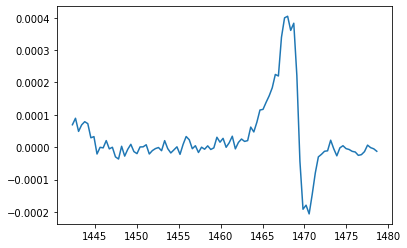

In [78]:
for i in source_energies:
    index0 = f_near(energies, i)
    plt.plot(energies[index0-50:index0+50], counts[index0-50:index0+50]/spec.livetime - bg_counts[index0-50:index0+50]/bg.livetime)
    #plt.yscale('log')
    plt.show()

In [107]:
roi.set_sideband(float(source_energies[0]), 2, [[-1, -.4], [-.7, 1.4], [1.0, 1.7]])
roi.set_sideband(float(source_energies[1]), 5, [[-1.8, -.5], [-.4, .8], [.9, 1.8]])
roi.set_sideband(float(source_energies[2]), 5, [[-5, -3], [-.4, 1], [2, 3.4]])
roi.set_sideband(float(source_energies[3]), 5, [[-2, -.8], [-.3, 1.5], [2.5, 3.5]])
roi.set_sideband(float(source_energies[4]), 9, [[-1.5, -.5], [-.05, 1.2], [1.5, 2.4]])
roi.set_sideband(float(source_energies[5]), 9, [[-1.4, -.4], [-.05, 1.3], [2, 3]])

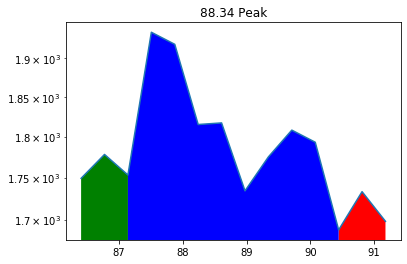

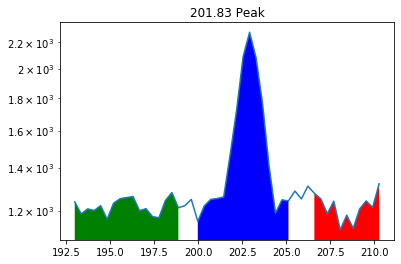

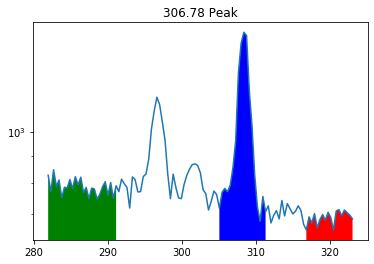

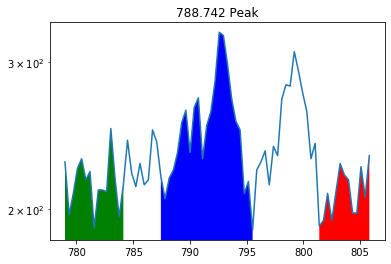

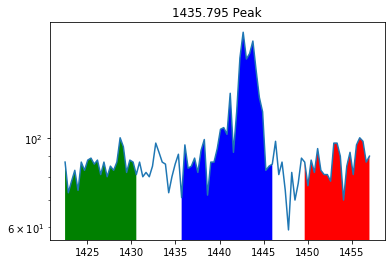

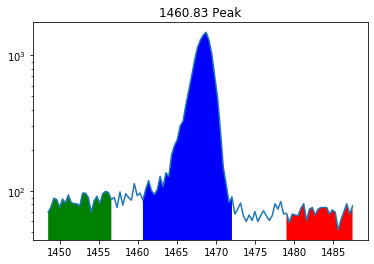

In [108]:
plot_peak_region(roi, spec, source_energies, float(source_energies[0]))
plot_peak_region(roi, spec, source_energies, float(source_energies[1]))
plot_peak_region(roi, spec, source_energies, float(source_energies[2]))
plot_peak_region(roi, spec, source_energies, float(source_energies[3]))
plot_peak_region(roi, spec, source_energies, float(source_energies[4]))
plot_peak_region(roi, spec, source_energies, float(source_energies[5]))

In [97]:
roi.set_sideband(float(source_energies[0]), 2,[[-1, -.4], [-.7, 1.4], [1.0, 1.7]], 1)
roi.set_sideband(float(source_energies[1]), 4, [[-1.8, -.5], [-.4, .6], [.8, 1.8]],1)
roi.set_sideband(float(source_energies[2]), 5, [[-5, -3], [-.4, .6], [.8, 3]],1)
roi.set_sideband(float(source_energies[3]), 7, [[-2, -.8], [-.1, 1.1], [1.9, 3]],1)
roi.set_sideband(float(source_energies[4]), 8, [[-2.8, -.8], [-.5, .6], [1, 3]],1)
roi.set_sideband(float(source_energies[5]), 10, [[-4, -2], [-.8, 1.2], [2, 3]],1)

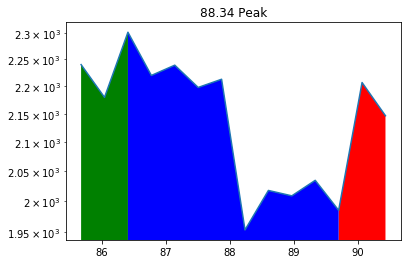

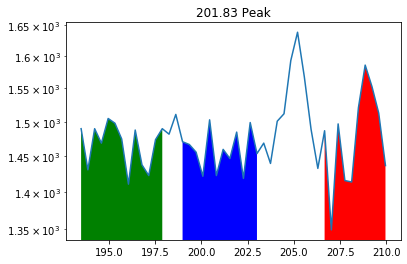

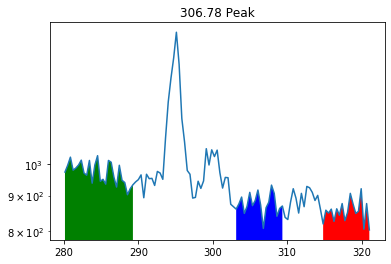

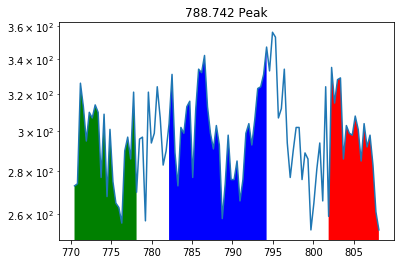

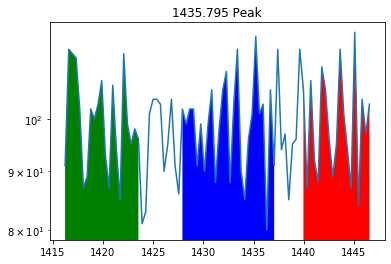

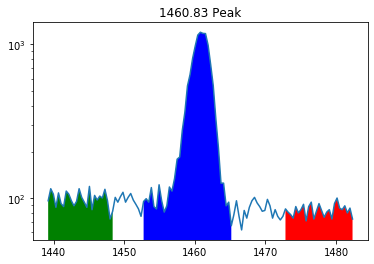

In [98]:
plot_peak_region(roi, bg, source_energies, float(source_energies[0]))
plot_peak_region(roi, bg, source_energies, float(source_energies[1]))
plot_peak_region(roi, bg, source_energies, float(source_energies[2]))
plot_peak_region(roi, bg, source_energies, float(source_energies[3]))
plot_peak_region(roi, bg, source_energies, float(source_energies[4]))
plot_peak_region(roi, bg, source_energies, float(source_energies[5]))

In [99]:
roi_counts=[]
roi_unc =[]
roi_counts, roi_unc = roi.get_counts()

background spec sidebands 6258.847908454548
bg peak counts 19063.347080797463
signal bg 5199.5
signal peak 18035.0
background spec sidebands 15404.335285128309
bg peak counts 13250.133499931546
signal bg 14076.499999999998
signal peak 18980.000000000004
background spec sidebands 23168.90080961042
bg peak counts 10368.485862265772
signal bg 16410.5
signal peak 17368.0
background spec sidebands 5596.295853180212
bg peak counts 6071.881164089461
signal bg 4459.0
signal peak 8447.0
background spec sidebands 4552.095661956756
bg peak counts 2083.862354671062
signal bg 1682.0000000000002
signal peak 2912.0000000000005
background spec sidebands 3410.327873552489
bg peak counts 13436.192638741462
signal bg 2063.9999999999995
signal peak 14809.0


In [100]:
print(roi_counts)
print(roi_unc)

[31.0008276570843, 7057.7017851967685, 13757.914947344647, 3512.4146890907514, 3698.2333072856945, 2719.1352348110267]
[206.9130236262136, 222.68484314471092, 221.59691566373064, 150.49870227080262, 83.58435733015045, 170.31960631647738]


In [101]:
eff,eff_uncer = efficiency(roi_counts,source_activities,branching_ratio,roi_unc,activities_uncer)
print(eff,eff_uncer)

[0.001732464346325104, 0.0504485344924433, 0.08997222668783461, 0.08865997716221202, 0.048089594774584465, 0.005818144820434546] [0.011564519241768203, 0.0052900119701244615, 0.009113183396363042, 0.003803006763809709, 0.001091127027953839, 0.00036461928543398775]


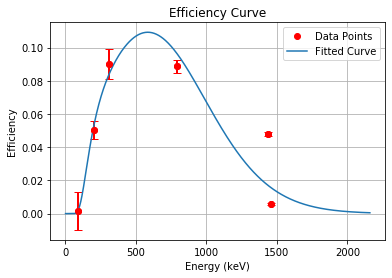

In [102]:
plot_eff = am.Efficiency(source_energies,eff,eff_uncer)

plot_eff.mutate()
plot_eff.fitting()
plot_eff.plotter()